# Visualize similar poses across age according to the model

In [1]:
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from toolz import groupby, valmap, compose
from toolz.curried import get, pluck
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from scipy.spatial.distance import cdist

from aging.plotting import format_plots, PlotConfig, save_factory, figure
from toolz import topk
from itertools import repeat

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / 'size-normalization', tight_layout=False)

In [3]:
folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_06/all_data_pca/Ontogeny_males')

In [4]:
files = sorted(folder.glob('*.h5'))

In [5]:
pattern = re.compile(r'(\d{1,2}[wm])')

In [6]:
def get_name(file):
    with h5py.File(file, 'r') as h5f:
        return h5f['metadata/acquisition/SessionName'][()].decode()

In [7]:
names = list(map(get_name, files))

In [8]:
ages = [pattern.search(n).group(0) for n in names]

In [9]:
grps = list(zip(ages, files))

In [10]:
groups = groupby(get(0), grps)
groups = valmap(compose(list, pluck(1)), groups)

## Get pose "classes" from 3 month old mice

In [27]:
frames_per_sample = 750
files_3m = groups['3m']
frames_key = 'win_size_norm_frames_v5'

np.random.seed(0)

frames = []
for file in tqdm(files_3m):
    try:
        with h5py.File(file, 'r') as h5f:
            indices = np.sort(np.random.permutation(len(h5f[frames_key]))[:frames_per_sample])
            data = h5f[frames_key][indices].astype('uint8')
            frames.append(data)

    except KeyError:
        continue

frames = np.concatenate(frames, axis=0)

  0%|          | 0/27 [00:00<?, ?it/s]

In [28]:
pca = PCA(n_components=10)
pcs = pca.fit_transform(frames.reshape(len(frames), -1))

In [29]:
pcs.shape

(20250, 10)

In [30]:
centroid, labels, inertia = k_means(pcs, n_clusters=14, random_state=0)

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
labels

array([ 0,  0, 10, ...,  3,  8,  8], dtype=int32)

In [32]:
np.bincount(labels)

array([3296,  526, 1907, 1776,  767, 2910,  456, 1472,  558,  352, 1747,
       1046,  696, 2741])

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


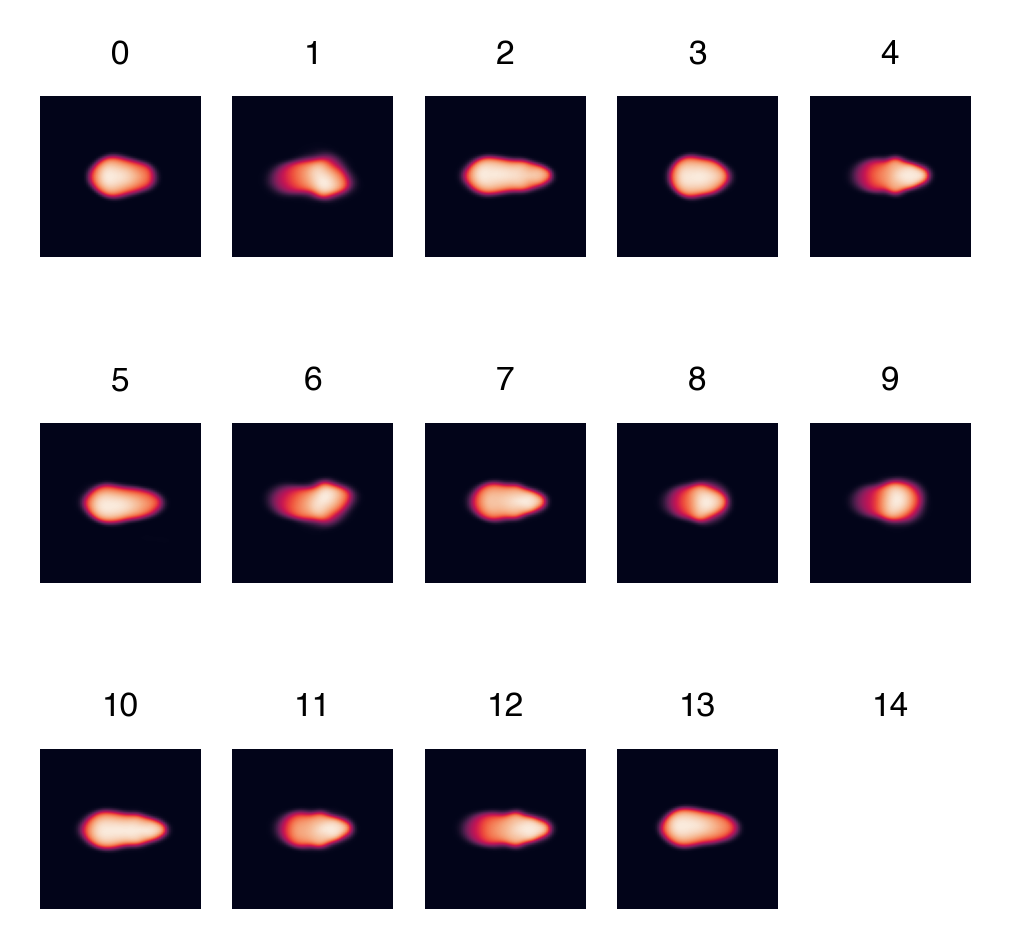

In [33]:
fig, ax = plt.subplots(3, 5)
for i, a in enumerate(ax.flat):
    a.imshow(np.mean(frames[labels == i], axis=0))
    a.set_title(i)
    a.set_axis_off()

- find most similar 3mo old animal to centroid
- then go through ages, find most similar animal to 3mo old in each age group

In [34]:
label_list = [3, 8, 2]

templates = {}
for label in label_list:
    examples = pcs[labels == label]
    topk_idx = cdist(examples, centroid[[label]]).squeeze().argmin()
    templates[label] = examples[topk_idx]

In [35]:
templates

{3: array([-36.17809448, 199.9092755 ,  31.82556997,  10.46499065,
         -5.03543596,   3.97893079,  39.2635083 ,  33.11711729,
         18.68739   ,  -0.47308512]),
 8: array([ 328.65347909,  222.7945064 ,    2.83916245,   86.56264196,
          22.38008595,   17.16986235, -103.06692555,   27.41656653,
          11.43359968,  -47.60567859]),
 2: array([ -65.59058729, -169.37397642,  -77.4934674 ,   10.79927962,
         -21.12049462,   27.69322871,   13.33939316,   29.25489353,
          -9.59402412,  -13.72831622])}

In [36]:
n_frames = 12_500

pc_dict = {}
for age, _files in tqdm(groups.items()):
    frames = {}
    for file in _files:
        with h5py.File(file, 'r') as h5f:
            data = h5f[frames_key][:n_frames].astype('uint8')
            frames[file] = pca.transform(data.reshape(len(data), -1))
    pc_dict[age] = frames

  0%|          | 0/11 [00:00<?, ?it/s]

In [37]:
n_best = 10
examples = {}
for age, frames in pc_dict.items():
    for lbl, template in templates.items():
        best_examples = []
        best_dist = np.inf
        for file, _frames in frames.items():
            dist = cdist(_frames, [template]).squeeze()
            topk_idx = dist.argmin()
            best = list(topk(n_best, zip(enumerate(repeat(file)), -dist), key=get(1)))
            best_examples.extend(best)
        examples[(age, lbl)] = list(pluck(0, topk(n_best, best_examples, key=get(1))))

In [38]:
def get_frame(idx, file):
    with h5py.File(file, 'r') as h5f:
        return (h5f[frames_key][idx].astype('uint8'), h5f['frames'][idx].astype('uint8'))

In [39]:
# loop through examples and load frames + reconstructions
example_frames = {}
for key, _topk in examples.items():
    example_frames[key] = [get_frame(*args) for args in _topk]

In [40]:
def week_translator(key):
    if 'm' in key:
        return int(key.replace('m', '')) * 4
    elif 'w' in key:
        return int(key.replace('w', ''))

In [41]:
keys = list(example_frames)
sorted_keys = sorted(sorted(keys, key=lambda x: week_translator(x[0])), key=lambda x: x[1])
grouped_keys = groupby(get(1), sorted_keys)

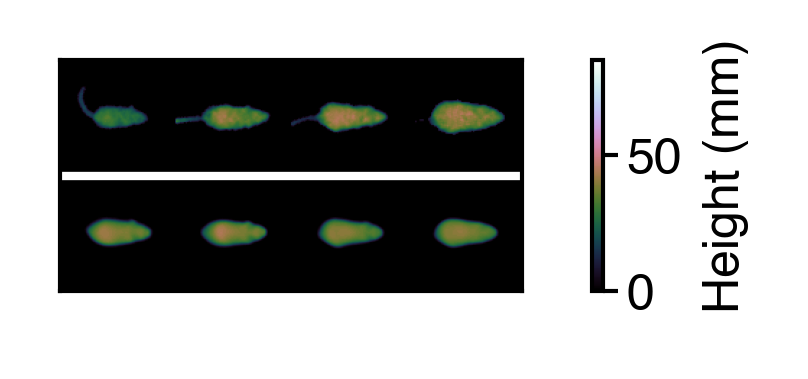

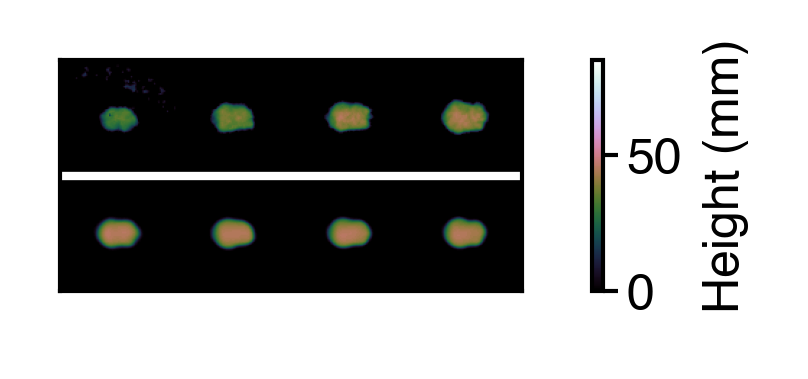

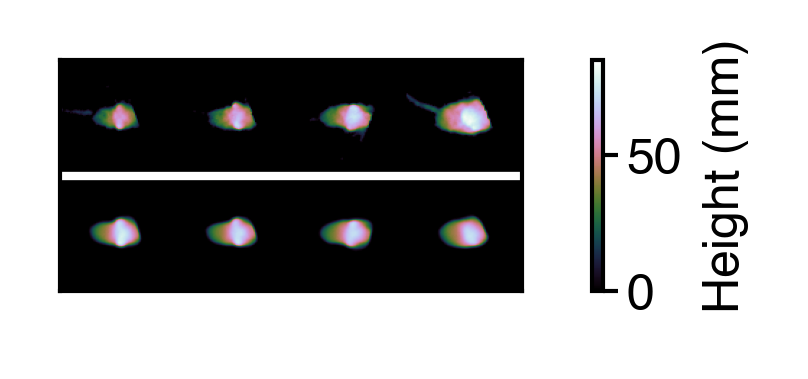

In [44]:
topk_idx = 2
inds = [0, 2, 4, 8]
for lbl, _keys in grouped_keys.items():
    concat = np.concatenate([example_frames[_keys[key]][topk_idx][0] for key in inds], axis=1)
    concat2 = np.concatenate([example_frames[_keys[key]][topk_idx][1] for key in inds], axis=1)
    concat = np.concatenate([concat2, concat], axis=0)
    fig = figure(1.5, 0.5)
    plt.imshow(concat, cmap='cubehelix', vmax=85)
    # for i in range(1, 4):
    #     plt.axvline(80 * i, color='w', lw=1)
    plt.axhline(80, color='w', lw=1)
    plt.colorbar(label='Height (mm)')
    plt.xticks([])
    plt.yticks([])
    saver(fig, f'same-pose-across-age-{lbl}');

In [43]:
[_keys[i] for i in inds]

[('3w', 8), ('7w', 8), ('3m', 8), ('18m', 8)]